<a href="https://colab.research.google.com/github/MoeMunci/Image_Forgery_Detection/blob/main/ImageForgery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## ResNet50 and Monte Carlo Dropout

In [ ]:
# Moses ResNet50

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, models, datasets
from PIL import Image
import os
from sklearn.metrics import confusion_matrix
from PIL import ImageFile
import numpy as np
from tqdm import tqdm

ImageFile.LOAD_TRUNCATED_IMAGES = True

# Define constants
target_size = (224, 224)
batch_size = 32
epochs = 5
dropout_rate = 0.5
dataset_path = "/content/drive/MyDrive/Columbia_dataset"
early_stopping_patience = 3

# Define the function to convert TIFF to JPEG
def convert_tiff_to_jpeg(image_path):
  try:
      image = Image.open(image_path)
      jpeg_path = os.path.splitext(image_path)[0] + ".jpeg"
      image.save(jpeg_path, "JPEG")
  except OSError as e:
      print(f"Error processing {image_path}: {e}")

# Convert TIFF and JPG to JPEG if needed
for folder in ['Original', 'Fake']:
    folder_path = os.path.join(dataset_path, folder)
    for filename in os.listdir(folder_path):
        if filename.endswith('.tif') or filename.endswith('.jpg'):
            convert_tiff_to_jpeg(os.path.join(folder_path, filename))

# Data transformations
data_transforms = {
    'Fake': transforms.Compose([
        transforms.RandomResizedCrop(target_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Original': transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Load datasets
dataset = datasets.ImageFolder(dataset_path, transform=data_transforms['Original'])

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define the model (using pre-trained ResNet) with Monte Carlo Dropout
class ResNet50Model(nn.Module):
    def __init__(self):
        super(ResNet50Model, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Sequential(
            nn.Linear(self.resnet.fc.in_features, 1024),
            nn.Dropout(p=dropout_rate),
            nn.ReLU(),
            nn.Linear(1024, 2)
        )
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        x = self.resnet(x)
        x = self.dropout(x)
        return x

# Create model instance
model = ResNet50Model()

# Define optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-5)
# Assuming you have a test_loader similar to train_loader and val_loader

# Initialize variables for early stopping
best_val_loss = float('inf')
early_stopping_counter = 0

# Initialize lists to store the training and validation scores for each epoch
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(epochs):
    model.train()
    running_train_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    epoch_train_loss = running_train_loss / len(train_loader)
    train_losses.append(epoch_train_loss)

    # Evaluation on validation set
    model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation"):
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_val_loss = running_val_loss / len(val_loader)
    val_losses.append(epoch_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)

    # Print train loss, validation loss, and validation accuracy
    print(f"Epoch {epoch+1}, Train Loss: {epoch_train_loss}, Validation Loss: {epoch_val_loss}, Validation Accuracy: {val_accuracy}%")

    # Check for early stopping
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping!")
            break

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    print("Confusion Matrix:")
    print(conf_matrix)

print('Finished Training')


# Define a function to perform Monte Carlo Dropout evaluation
def mc_dropout_evaluation(model, dataloader, num_samples):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()

    correct = 0
    total = 0
    mc_dropout_outputs = []
    all_outputs = []
    with torch.no_grad():
        for data in dataloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs_list = []
            for _ in range(num_samples):
                outputs = model(images)
                outputs_list.append(outputs)
                all_outputs.extend(outputs.cpu().numpy())
            mc_dropout_outputs.append(outputs_list)

            # Convert the list of tensors to a tensor
            stacked_outputs = torch.stack(outputs_list, dim=0)

            # Take the mean over the samples
            _, predicted = torch.max(torch.mean(stacked_outputs, dim=0), 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    # Calculate the average and standard deviation of the model's output
    average = torch.mean(torch.tensor(all_outputs))
    stddev = torch.std(torch.tensor(all_outputs))

    return accuracy, average.item(), stddev.item()


# Define a function to evaluate the model
def evaluate_model(model, dataloader, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    loss = running_loss / len(dataloader)
    return accuracy, loss

# Evaluate the model on the validation set
validation_accuracy, validation_loss = evaluate_model(model, val_loader, criterion)
print(f"Validation accuracy: {validation_accuracy}")
print(f"Validation loss: {validation_loss}")

# Perform Monte Carlo Dropout evaluation
num_samples = 5  # Number of Monte Carlo samples
mc_dropout_accuracy, mc_dropout_average, mc_dropout_stddev = mc_dropout_evaluation(model, val_loader, num_samples)
print(f"Monte Carlo Dropout accuracy: {mc_dropout_accuracy}")
print(f"Monte Carlo Dropout average: {mc_dropout_average}")
print(f"Monte Carlo Dropout standard deviation: {mc_dropout_stddev}")

# Save the model
torch.save(model.state_dict(), "image_forgery_detector_ResNet.pth")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 140MB/s]
Validation: 100%|██████████| 12/12 [01:33<00:00,  7.78s/it]


Epoch 1, Train Loss: 0.5356403381928153, Validation Loss: 0.3124697394669056, Validation Accuracy: 91.48351648351648%
Confusion Matrix:
[[172   9]
 [ 22 161]]


Validation: 100%|██████████| 12/12 [01:06<00:00,  5.53s/it]


Epoch 2, Train Loss: 0.34286273238451587, Validation Loss: 0.2092197723686695, Validation Accuracy: 95.87912087912088%
Confusion Matrix:
[[178   3]
 [ 12 171]]


Validation: 100%|██████████| 12/12 [01:05<00:00,  5.43s/it]


Epoch 3, Train Loss: 0.25882853599994077, Validation Loss: 0.1301080882549286, Validation Accuracy: 98.07692307692308%
Confusion Matrix:
[[178   3]
 [  4 179]]


Validation: 100%|██████████| 12/12 [01:05<00:00,  5.49s/it]


Epoch 4, Train Loss: 0.23937183327001074, Validation Loss: 0.09443188862254222, Validation Accuracy: 97.8021978021978%
Confusion Matrix:
[[175   6]
 [  2 181]]


Validation: 100%|██████████| 12/12 [01:04<00:00,  5.36s/it]


Epoch 5, Train Loss: 0.22238673172567203, Validation Loss: 0.053218274066845574, Validation Accuracy: 99.72527472527473%
Confusion Matrix:
[[180   1]
 [  0 183]]
Finished Training
Validation accuracy: 0.9972527472527473
Validation loss: 0.053218274066845574


<ipython-input-2-49e23fb89ca6>:193: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  average = torch.mean(torch.tensor(all_outputs))


Monte Carlo Dropout accuracy: 0.9917582417582418
Monte Carlo Dropout average: 0.057605721056461334
Monte Carlo Dropout standard deviation: 2.705108880996704


Saving canong3_canonxt_sub_16.jpg to canong3_canonxt_sub_16 (2).jpg
The image is predicted to be a forgery with a confidence of 99.72587585449219%


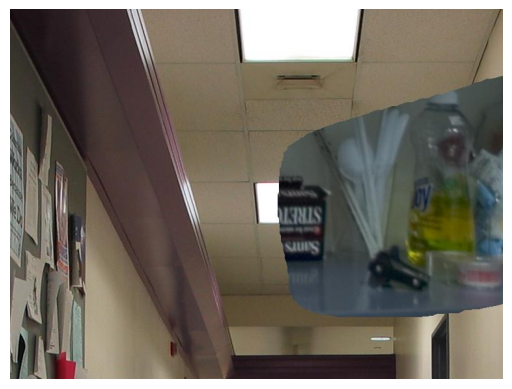

In [ ]:
# Francis

from google.colab import files
from PIL import Image
from torchvision import transforms
import torch
import io
import matplotlib.pyplot as plt

# Load the trained model
model = ResNet50Model()
model.load_state_dict(torch.load("image_forgery_detector_ResNet.pth"))
model.eval()

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Upload the image
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

# Open and transform the image
image = Image.open(image_path).convert('RGB')
image_tensor = transform(image).unsqueeze(0)

# Predict the class of the image
output = model(image_tensor)
_, predicted = torch.max(output, 1)
probabilities = torch.nn.functional.softmax(output, dim=1)[0] * 100

# Print the result
if predicted == 0:
    print(f"The image is predicted to be a forgery with a confidence of {probabilities[0].item()}%")
else:
    print(f"The image is predicted to be original with a confidence of {probabilities[1].item()}%")

# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()


### ViT Model

In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 31.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

In [ ]:
# Michael ViT

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from PIL import Image
import os
from sklearn.metrics import confusion_matrix
import numpy as np
from tqdm import tqdm
import timm
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define constants
target_size = (224, 224)
batch_size = 32
epochs = 5
dropout_rate = 0.5
dataset_path = "/content/drive/MyDrive/Columbia_dataset"
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Define the function to convert TIFF to JPEG
def convert_tiff_to_jpeg(tiff_path):
    try:
        image = Image.open(tiff_path)
        jpeg_path = tiff_path.replace(".tif", ".jpeg")
        image.save(jpeg_path, "JPEG")
    except OSError as e:
        print(f"Error processing {tiff_path}: {e}")

# Convert TIFF to JPEG if needed
for folder in ['Original', 'Fake']:
    folder_path = os.path.join(dataset_path, folder)
    for filename in os.listdir(folder_path):
        if filename.endswith('.tif'):
            convert_tiff_to_jpeg(os.path.join(folder_path, filename))

# Data transformations
data_transforms = {
    'Original': transforms.Compose([
        transforms.RandomResizedCrop(target_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Fake': transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Load datasets
dataset = datasets.ImageFolder(dataset_path, transform=data_transforms['Original'])

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define the ViT model
class ViTModel(nn.Module):
    def __init__(self):
        super(ViTModel, self).__init__()
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True)
        self.vit.head = nn.Identity()  # Remove the original classifier
        self.fc = nn.Linear(768, 2)  # Change the input size to 768
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.vit(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Create model instance
model = ViTModel().to(device)
# Modify last layer
model.fc = nn.Linear(768, len(dataset.classes)).to(device)

# Define optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-4)

# Training loop
for epoch in range(epochs):
    model.train()
    running_train_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    epoch_train_loss = running_train_loss / len(train_loader)

    # Evaluation on validation set
    model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_val_loss = running_val_loss / len(val_loader)
    val_accuracy = 100 * correct / total

    # Print train loss, validation loss, and validation accuracy
    print(f"Epoch {epoch+1}, Train Loss: {epoch_train_loss}, Validation Loss: {epoch_val_loss}, Validation Accuracy: {val_accuracy}%")

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    print("Confusion Matrix:")
    print(conf_matrix)

print('Finished training')

# Define a function to evaluate the model
def evaluate_model(model, dataloader, criterion):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    loss = running_loss / len(dataloader)
    return accuracy, loss

# Enable MC Dropout during evaluation
model.train()

# Define a function to perform Monte Carlo Dropout evaluation
def mc_dropout_evaluation(model, dataloader, num_samples):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()

    correct = 0
    total = 0
    mc_dropout_outputs = []
    all_outputs = []
    with torch.no_grad():
        for data in dataloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs_list = []
            for _ in range(num_samples):
                outputs = model(images)
                outputs_list.append(outputs)
                all_outputs.extend(outputs.cpu().numpy())
            mc_dropout_outputs.append(outputs_list)

            # Convert the list of tensors to a tensor
            stacked_outputs = torch.stack(outputs_list, dim=0)

            # Take the mean over the samples
            _, predicted = torch.max(torch.mean(stacked_outputs, dim=0), 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    # Calculate the average and standard deviation of the model's output
    average = torch.mean(torch.tensor(all_outputs))
    stddev = torch.std(torch.tensor(all_outputs))

    return accuracy, average.item(), stddev.item()

# Perform Monte Carlo Dropout evaluation
num_samples = 5  # Number of Monte Carlo samples
mc_dropout_accuracy, mc_dropout_average, mc_dropout_stddev = mc_dropout_evaluation(model, val_loader, num_samples)
print(f"Monte Carlo Dropout accuracy: {mc_dropout_accuracy}")
print(f"Monte Carlo Dropout average: {mc_dropout_average}")
print(f"Monte Carlo Dropout standard deviation: {mc_dropout_stddev}")

# Evaluate the model on the validation set
validation_accuracy, validation_loss = evaluate_model(model, val_loader, criterion)
print(f"Validation accuracy: {validation_accuracy}")
print(f"Validation loss: {validation_loss}")

# Save the model
torch.save(model.state_dict(), "image_forgery_detector_ViT.pth")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Validation: 100%|██████████| 12/12 [03:26<00:00, 17.20s/it]


Epoch 1, Train Loss: 0.9356544432432755, Validation Loss: 0.6859845916430155, Validation Accuracy: 52.747252747252745%
Confusion Matrix:
[[ 96  61]
 [111  96]]


Validation: 100%|██████████| 12/12 [03:25<00:00, 17.16s/it]


Epoch 2, Train Loss: 0.8217748092568439, Validation Loss: 0.6339331790804863, Validation Accuracy: 60.989010989010985%
Confusion Matrix:
[[104  53]
 [ 89 118]]


Validation: 100%|██████████| 12/12 [03:36<00:00, 18.02s/it]


Epoch 3, Train Loss: 0.7464459285787914, Validation Loss: 0.5848716447750727, Validation Accuracy: 67.03296703296704%
Confusion Matrix:
[[109  48]
 [ 72 135]]


Validation: 100%|██████████| 12/12 [03:45<00:00, 18.76s/it]


Epoch 4, Train Loss: 0.690497381531674, Validation Loss: 0.5507460087537766, Validation Accuracy: 70.87912087912088%
Confusion Matrix:
[[125  32]
 [ 74 133]]


Validation: 100%|██████████| 12/12 [03:34<00:00, 17.89s/it]


Epoch 5, Train Loss: 0.6746874963459761, Validation Loss: 0.5295781642198563, Validation Accuracy: 73.35164835164835%
Confusion Matrix:
[[120  37]
 [ 60 147]]
Finished training
Monte Carlo Dropout accuracy: 0.7005494505494505
Monte Carlo Dropout average: -0.11739218235015869
Monte Carlo Dropout standard deviation: 1.1413660049438477
Validation accuracy: 0.7142857142857143
Validation loss: 0.5396734004219373


Saving nikond70_kodakdcs330_sub_23.jpeg to nikond70_kodakdcs330_sub_23.jpeg
The image is predicted to be a forgery with a confidence of 98.41920471191406%


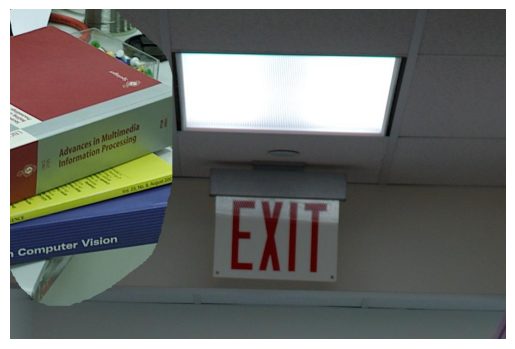

In [ ]:
# Francis

from google.colab import files
from PIL import Image
from torchvision import transforms
import torch
import io
import matplotlib.pyplot as plt

# Load the trained model
model = ViTModel()
model.load_state_dict(torch.load("image_forgery_detector_ViT.pth"))
model.eval()

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Upload the image
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

# Open and transform the image
image = Image.open(image_path).convert('RGB')
image_tensor = transform(image).unsqueeze(0)

# Predict the class of the image
output = model(image_tensor)
_, predicted = torch.max(output, 1)
probabilities = torch.nn.functional.softmax(output, dim=1)[0] * 100

# Print the result
if predicted == 0:
    print(f"The image is predicted to be a forgery with a confidence of {probabilities[0].item()}%")
else:
    print(f"The image is predicted to be original with a confidence of {probabilities[1].item()}%")

# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()